In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from statistics import mode
import tensorflow as tf
import random
import os
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

In [399]:
# Read the CSV file to classify whether the student has a A score 
df_matA = pd.read_csv('mat_A.csv', sep=',')
data = df_matA.to_numpy()[:, 1:]

# standarize the data 
indices_to_standarize = []
for i, feature in enumerate(data[0]):
    if type(feature) != str and i != (data.shape[1]-1):
        indices_to_standarize.append(i)

for i in indices_to_standarize:
    m = np.mean(data[:, i])
    std = np.std(data[:, i])
    data[:, i] = (data[:, i]-m)/std

# split in to training and testing
X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.1, random_state=0)

In [400]:
def dist(x1, x2):
    total_dist = 0
    
    for i, feature in enumerate(x1):
        # for numerical values, the distance is manhattan
        if type(feature) != str:
            total_dist += abs(x1[i] - x2[i])
        # for categorical values, the distance is hamming
        else:
            if x1[i] != x2[i]:
                total_dist += 1
    return total_dist

In [401]:
def find_min(dists, k):
    x_sorted = np.sort(dists)
    min_values = x_sorted[:k]
    indices = [dists.index(value) for value in min_values]
    return indices
    

In [402]:
# knn
def knn(X_train, X_test, y_train, y_test, k):

    y_pred = []

    # for each test data
    for x in X_test:
        
        # get an array represent the distance between x and each training data
        distances = []
        for x_train in X_train:
            distances.append(dist(x, x_train))
        
        # find the k lowest distance
        lowest_indices = find_min(distances, k)
        
        # majority vote from these k
        pred = mode(y_train[lowest_indices])
        
        # append the predicted result to the prediction array
        y_pred.append(pred)
        
    accuracy = sum(y_pred == y_test)/len(y_pred)
    return accuracy

In [403]:
# ANN
def ann(data, unit_num1, act_func1, unit_num2, act_func2, unit_num3, act_func3):
    random_seed = 0
    os.environ['PYTHONHASHSEED']=str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    
    # process data by change yes/no to 0/1 and delete all categorical data:
    new_data = data.copy()
    columns_to_delete = []
    for sample in new_data:
        for i in range(len(sample)):
            if sample[i] == 'yes':
                sample[i] = 1
            elif sample[i] == 'no':
                sample[i] = 0
    for i in range(len(new_data[0])):
        if type(new_data[i][i]) == str:
            columns_to_delete.append(i)

    new_data = np.delete(new_data, columns_to_delete, axis = 1)
    # split in to training and testing
    X_train, X_test, y_train, y_test = train_test_split(new_data[:, :-1], new_data[:, -1], test_size=0.1, random_state=0)

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

    # Initialize the ANN model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=unit_num1, activation=act_func1))
    model.add(tf.keras.layers.Dense(units=unit_num2, activation=act_func2))
    model.add(tf.keras.layers.Dense(units=unit_num3, activation=act_func3))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=100)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    return accuracy

In [404]:
def decision_tree(data, crit, split, max_dep, min_samp_split):
    # decision tree
    # process data by change yes/no to 0/1 and delete all categorical data:
    new_data = data.copy()
    columns_to_delete = []
    for sample in new_data:
        for i in range(len(sample)):
            if sample[i] == 'yes':
                sample[i] = 1
            elif sample[i] == 'no':
                sample[i] = 0
    for i in range(len(new_data[0])):
        if type(new_data[i][i]) == str:
            columns_to_delete.append(i)

    new_data = np.delete(new_data, columns_to_delete, axis = 1)
    # split in to training and testing
    X_train, X_test, y_train, y_test = train_test_split(new_data[:, :-1], new_data[:, -1], test_size=0.1, random_state=0)
    y_train = y_train.tolist()
    y_test = y_test.tolist()

    # Creating a decision tree classifier
    clf = DecisionTreeClassifier(criterion=crit, splitter=split, max_depth=max_dep, min_samples_split=min_samp_split, random_state=0)

    # Fitting the classifier to the training data
    clf.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = clf.predict(X_test)  # clf is your trained decision tree classifier

    # Evaluating the classifier
    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [405]:
print(knn(X_train, X_test, y_train, y_test, 5))
print(ann(data, 64, 'relu', 32, 'relu', 1, 'sigmoid'))
print(decision_tree(data, 'gini', 'best', 10, 3))

0.925
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.4867 - loss: 0.7149
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.8048 - loss: 0.5567
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.8348 - loss: 0.4719
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.8678 - loss: 0.3995
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.9009 - loss: 0.3340
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.9181 - loss: 0.2813
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.9180 - loss: 0.2410
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.9302 - loss: 0.2112
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.9324 - loss: 0.1875
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.9377 - loss: 0.1690
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.9427 - loss: 0.1537
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━

In [406]:
def random_forest(data, n_estimators, criterion, max_depth, min_samples_split):
    # decision tree
    # process data by change yes/no to 0/1 and delete all categorical data:
    new_data = data.copy()
    columns_to_delete = []
    for sample in new_data:
        for i in range(len(sample)):
            if sample[i] == 'yes':
                sample[i] = 1
            elif sample[i] == 'no':
                sample[i] = 0
    for i in range(len(new_data[0])):
        if type(new_data[i][i]) == str:
            columns_to_delete.append(i)
    
    new_data = np.delete(new_data, columns_to_delete, axis = 1)
    # split in to training and testing
    X_train, X_test, y_train, y_test = train_test_split(new_data[:, :-1], new_data[:, -1], test_size=0.1, random_state=0)
    y_train = y_train.tolist()
    y_test = y_test.tolist()
    
    rf_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42) 
    rf_model.fit(X_train, y_train)
    
    predictions = rf_model.predict(X_test)
    
    return accuracy_score(y_test, predictions)




In [407]:
print(knn(X_train, X_test, y_train, y_test, 5))
print(ann(data, 64, 'relu', 32, 'relu', 1, 'sigmoid'))
print(decision_tree(data, 'gini', 'best', 10, 3))
print(random_forest(data, 100, "gini", 10, 2))

0.925
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.4867 - loss: 0.7149
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.8048 - loss: 0.5567
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.8348 - loss: 0.4719
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.8678 - loss: 0.3995
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.9009 - loss: 0.3340
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9181 - loss: 0.2813
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.9180 - loss: 0.2410
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.9302 - loss: 0.2112
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.9324 - loss: 0.1875
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.9377 - loss: 0.1690
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.9427 - loss: 0.1537
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━

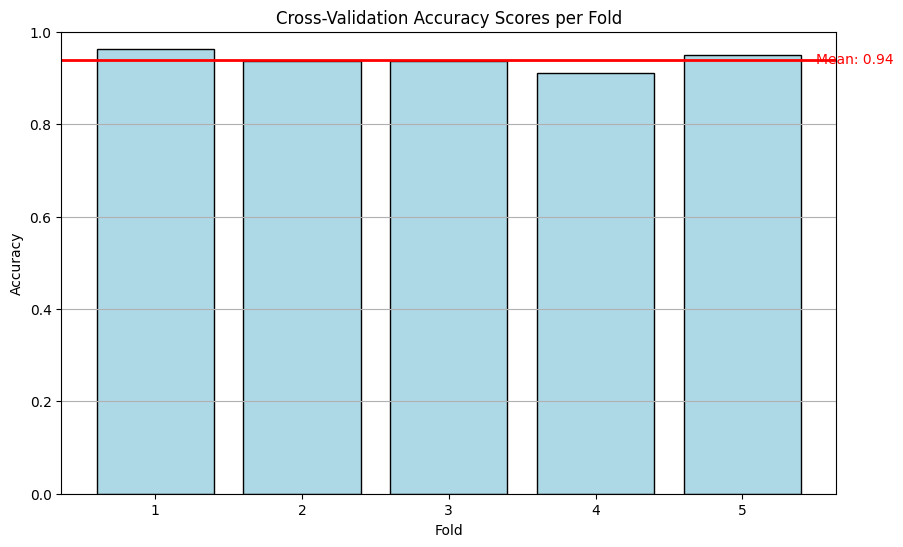

Mean Accuracy: 0.9392405063291139
Standard Deviation of Accuracy: 0.01679303691319191


In [416]:
# cross validation random forest

def random_forest_cv(data, n_estimators, criterion, max_depth, min_samples_split):
    # Process data
    new_data = data.copy()
    columns_to_delete = []
    for sample in new_data:
        for i in range(len(sample)):
            if sample[i] == 'yes':
                sample[i] = 1
            elif sample[i] == 'no':
                sample[i] = 0
    for i in range(len(new_data[0])):
        if type(new_data[i][i]) == str:
            columns_to_delete.append(i)
    new_data = np.delete(new_data, columns_to_delete, axis = 1)
    data = new_data

    # Define the model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, 
                                      max_depth=max_depth, 
                                      min_samples_split=min_samples_split, 
                                      random_state=42)

    # Split data into features and target
    X = data[:, :-1]
    y = data[:, -1]
    y = y.tolist()

    # Define K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    # Perform cross-validation
    cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    folds = range(1, 6)  # Folds: 1, 2, 3, 4, 5
    plt.bar(folds, cv_scores, color='lightblue', edgecolor='black')
    plt.axhline(y=mean_accuracy, color='r', linestyle='-', linewidth=2)
    plt.text(5.5, mean_accuracy, f'Mean: {mean_accuracy:.2f}', color = 'red', va='center')

    plt.title('Cross-Validation Accuracy Scores per Fold')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(folds)
    plt.ylim(0, 1)  # Assuming accuracy scores are between 0 and 1
    plt.grid(True, axis='y')
    plt.show()


    return np.mean(cv_scores), np.std(cv_scores)

# Example usage with your data
mean_accuracy, std_accuracy = random_forest_cv(data, n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
